In [38]:
##Churn Challenge

'''
https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction

https://medium.com/@lucapetriconi/churn-modeling-a-detailed-step-by-step-guide-in-python-1e96d51c7523
'''

# 2.3 Scaling - StandardScaler -> Can't encode too soon OR! have to encode everything but the Churn variable! 
# Create a dataframe that doesn't have churn, then scale, then recombine and see the effect on the scaled variables - DONE!

# 2.4 Feature Selection - SelectKBest -> !! Need to select best features - What are the thresholds for rejecting variables though?

# 4.0 Resolve k_range issues at the end of the notebook - DONE!

# 1.0 for recasting and changing the data etc.  only apply this to the dfing data set and leave the test alone.  
# Later when testing the model, apply those changes to the test data set as well.

# For categorical data use a percentage par chart instead of matrix chart

# Between step 3 and 4 create a pipeline for the test data as well.

## Why two dfing/test splits? 

###################################################################

## Look for Q-cut function and apply at the end of the model to quartile the output

## Look into feature selection and tuning the models once created.  Hyperparameter tuning for the random forest model and stopping rules etc of the model to improve performance and explain.  get_pameters() function?  Iterate and see what works best for random forest.




'\nhttps://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction\n\nhttps://medium.com/@lucapetriconi/churn-modeling-a-detailed-step-by-step-guide-in-python-1e96d51c7523\n'

In [94]:
## Basics 
import numpy as np
import pandas as pd
## Visualization
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
## ML
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, RocCurveDisplay
## Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
## Open File
import openpyxl
## Remove Warnings
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

ImportError: cannot import name 'plot_roc_curve' from 'sklearn.metrics' (c:\Users\urife\OneDrive\Desktop\Projects\Churn\venv\Lib\site-packages\sklearn\metrics\__init__.py)

In [40]:
# Path to your Excel file
file_path = 'E Commerce Dataset.xlsx'

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path, engine='openpyxl', sheet_name='E Comm')

In [41]:
# Shape of dataframe
df.shape

(5630, 20)

In [42]:
# 1. Exploratory Data Analysis

In [43]:
## Looking at data types and correct those wrongly encoded
df.dtypes

CustomerID                       int64
Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                 float64
dtype: object

In [44]:
def missing_values(data):
    # Initialize a list to collect results
    results = []
    
    for col in data.columns:
        # Get unique values
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except Exception:
            pass
        
        # Calculate metrics
        nans = round(pd.isna(data[col]).sum() / data.shape[0] * 100, 1)
        zeros = round((data[col] == 0).sum() / data.shape[0] * 100, 1)
        
        # Append metrics to the results list
        results.append({
            'variable': col,
            'Unique values': len(unique_values),
            'Nan %': nans,
            'zeros %': zeros
        })
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort results by 'Nan %' in descending order
    results_df = results_df.sort_values('Nan %', ascending=False)
    
    return results_df

print(missing_values(df))

                       variable  Unique values  Nan %  zeros %
18            DaySinceLastOrder             23    5.5      8.8
2                        Tenure             37    4.7      9.0
15  OrderAmountHikeFromlastYear             17    4.7      0.0
17                   OrderCount             17    4.6      0.0
16                   CouponUsed             18    4.5     18.3
8                HourSpendOnApp              7    4.5      0.1
5               WarehouseToHome             35    4.5      0.0
0                    CustomerID           5630    0.0      0.0
3          PreferredLoginDevice              3    0.0      0.0
1                         Churn              2    0.0     83.2
6          PreferredPaymentMode              7    0.0      0.0
4                      CityTier              3    0.0      0.0
11            SatisfactionScore              5    0.0      0.0
10             PreferedOrderCat              6    0.0      0.0
9      NumberOfDeviceRegistered              6    0.0  

In [45]:
# Replace missing values with -1 and recast values
df['Tenure'] = df['Tenure'].fillna(-1).astype('Int64')
df['WarehouseToHome'] = df['WarehouseToHome'].fillna(-1).astype('Int64')
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(-1).astype('Int64')
df['CouponUsed'] = df['CouponUsed'].fillna(-1).astype('Int64')
df['OrderCount'] = df['OrderCount'].fillna(-1).astype('Int64')
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(-1).astype('Int64')

#Filling in Nulls but don't need to recast
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(-1)
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(-1)

#PreferedOrderCat is misspelled
df['PreferredOrderCat'] = df['PreferedOrderCat']

#Remove PreferedOrderCat and CustomerID from the dataframe
df = df.drop(columns=['PreferedOrderCat'])
df = df.drop(columns=['CustomerID'])

In [46]:
df.head

<bound method NDFrame.head of       Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0         1       4         Mobile Phone         3                6   
1         1      -1                Phone         1                8   
2         1      -1                Phone         1               30   
3         1       0                Phone         3               15   
4         1       0                Phone         1               12   
...     ...     ...                  ...       ...              ...   
5625      0      10             Computer         1               30   
5626      0      13         Mobile Phone         1               13   
5627      0       1         Mobile Phone         1               11   
5628      0      23             Computer         3                9   
5629      0       8         Mobile Phone         1               15   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0              Debit Card  Female     

In [47]:
## Looking at data types and correct those wrongly encoded
df.dtypes

Churn                            int64
Tenure                           Int64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                  Int64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear      Int64
CouponUsed                       Int64
OrderCount                       Int64
DaySinceLastOrder                Int64
CashbackAmount                 float64
PreferredOrderCat               object
dtype: object

In [48]:
df.isnull().sum()

Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
PreferredOrderCat              0
dtype: int64

In [49]:
# Count NaN values for each column
nan_count_per_column = df.isna().sum()
print("NaN values per column:")
print(nan_count_per_column)

NaN values per column:
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
PreferredOrderCat              0
dtype: int64


In [50]:
# Filter rows where any column has NaN
rows_with_nan = df[df.isna().any(axis=1)]
print("Rows with NaN values:")
print(rows_with_nan)

Rows with NaN values:
Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount, PreferredOrderCat]
Index: []


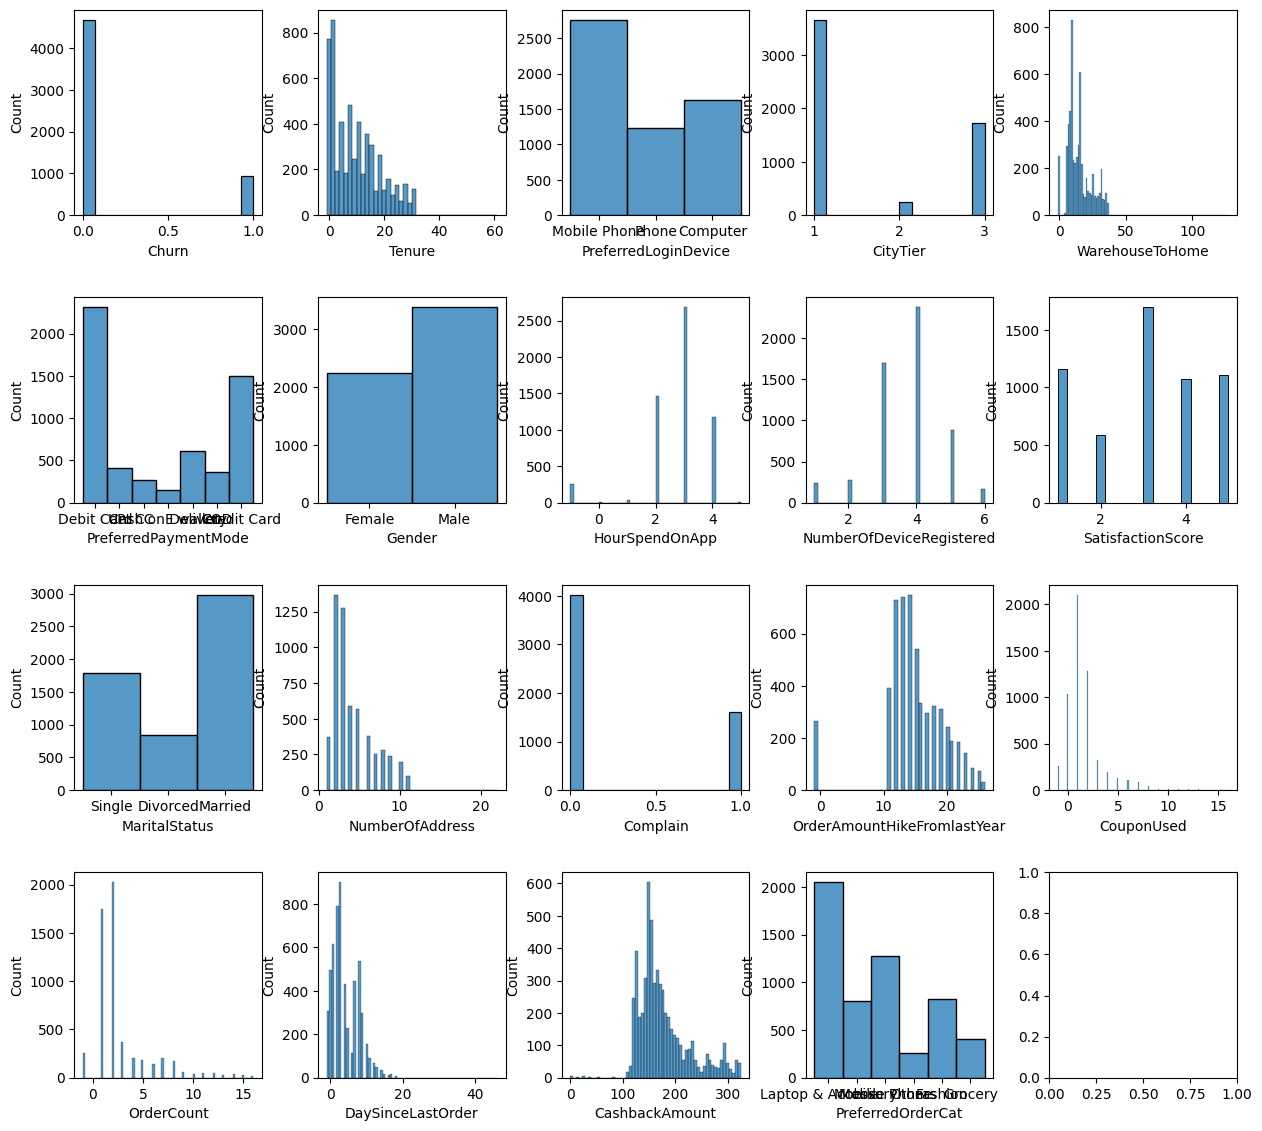

In [51]:
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.3, hspace=0.4)
for variable, subplot in zip(df.columns, ax.flatten()):
  sns.histplot(df[variable], ax=subplot)

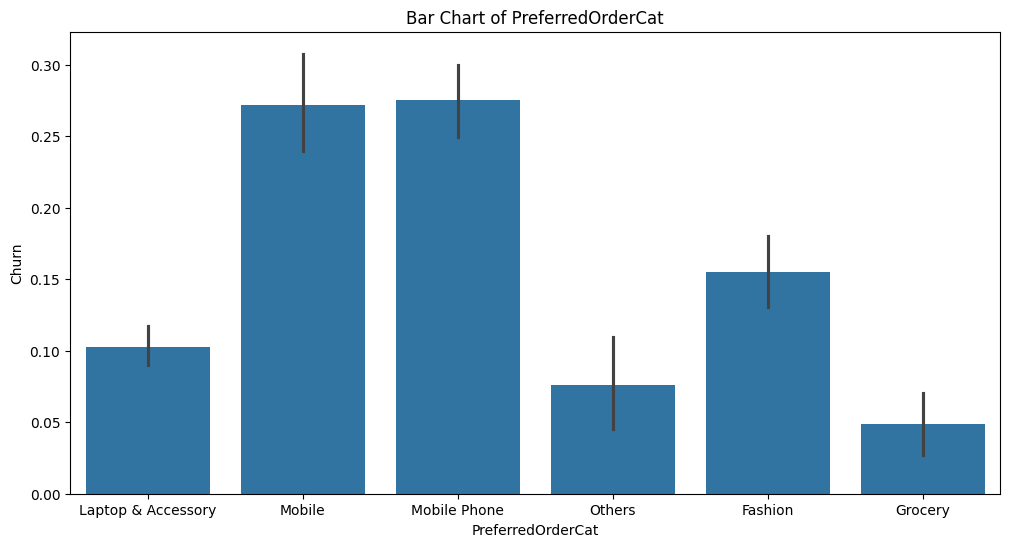

In [52]:
# Adjust figure size
plt.figure(figsize=(12, 6))  # Increase width (12) and height (6)

# Plot Bar Chart of PreferredOrderCat
sns.barplot(data=df, x='PreferredOrderCat', y='Churn')
plt.title('Bar Chart of PreferredOrderCat')
plt.xlabel('PreferredOrderCat')
plt.ylabel('Churn')
plt.show()

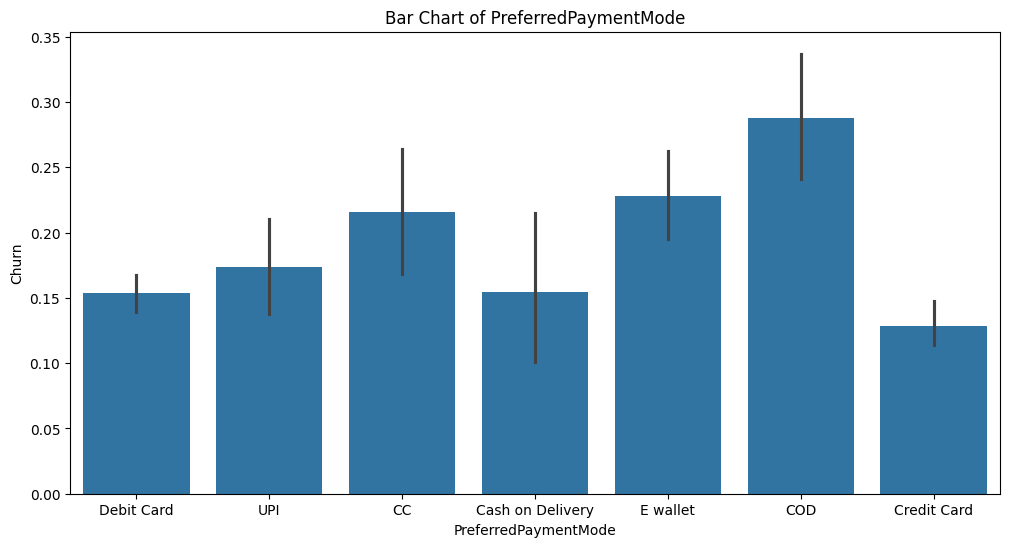

In [53]:
# Adjust figure size
plt.figure(figsize=(12, 6))  # Increase width (12) and height (6)

# Plot Bar Chart of PreferredPaymentMode
sns.barplot(data=df, x='PreferredPaymentMode', y='Churn')
plt.title('Bar Chart of PreferredPaymentMode')
plt.xlabel('PreferredPaymentMode')
plt.ylabel('Churn')
plt.show()

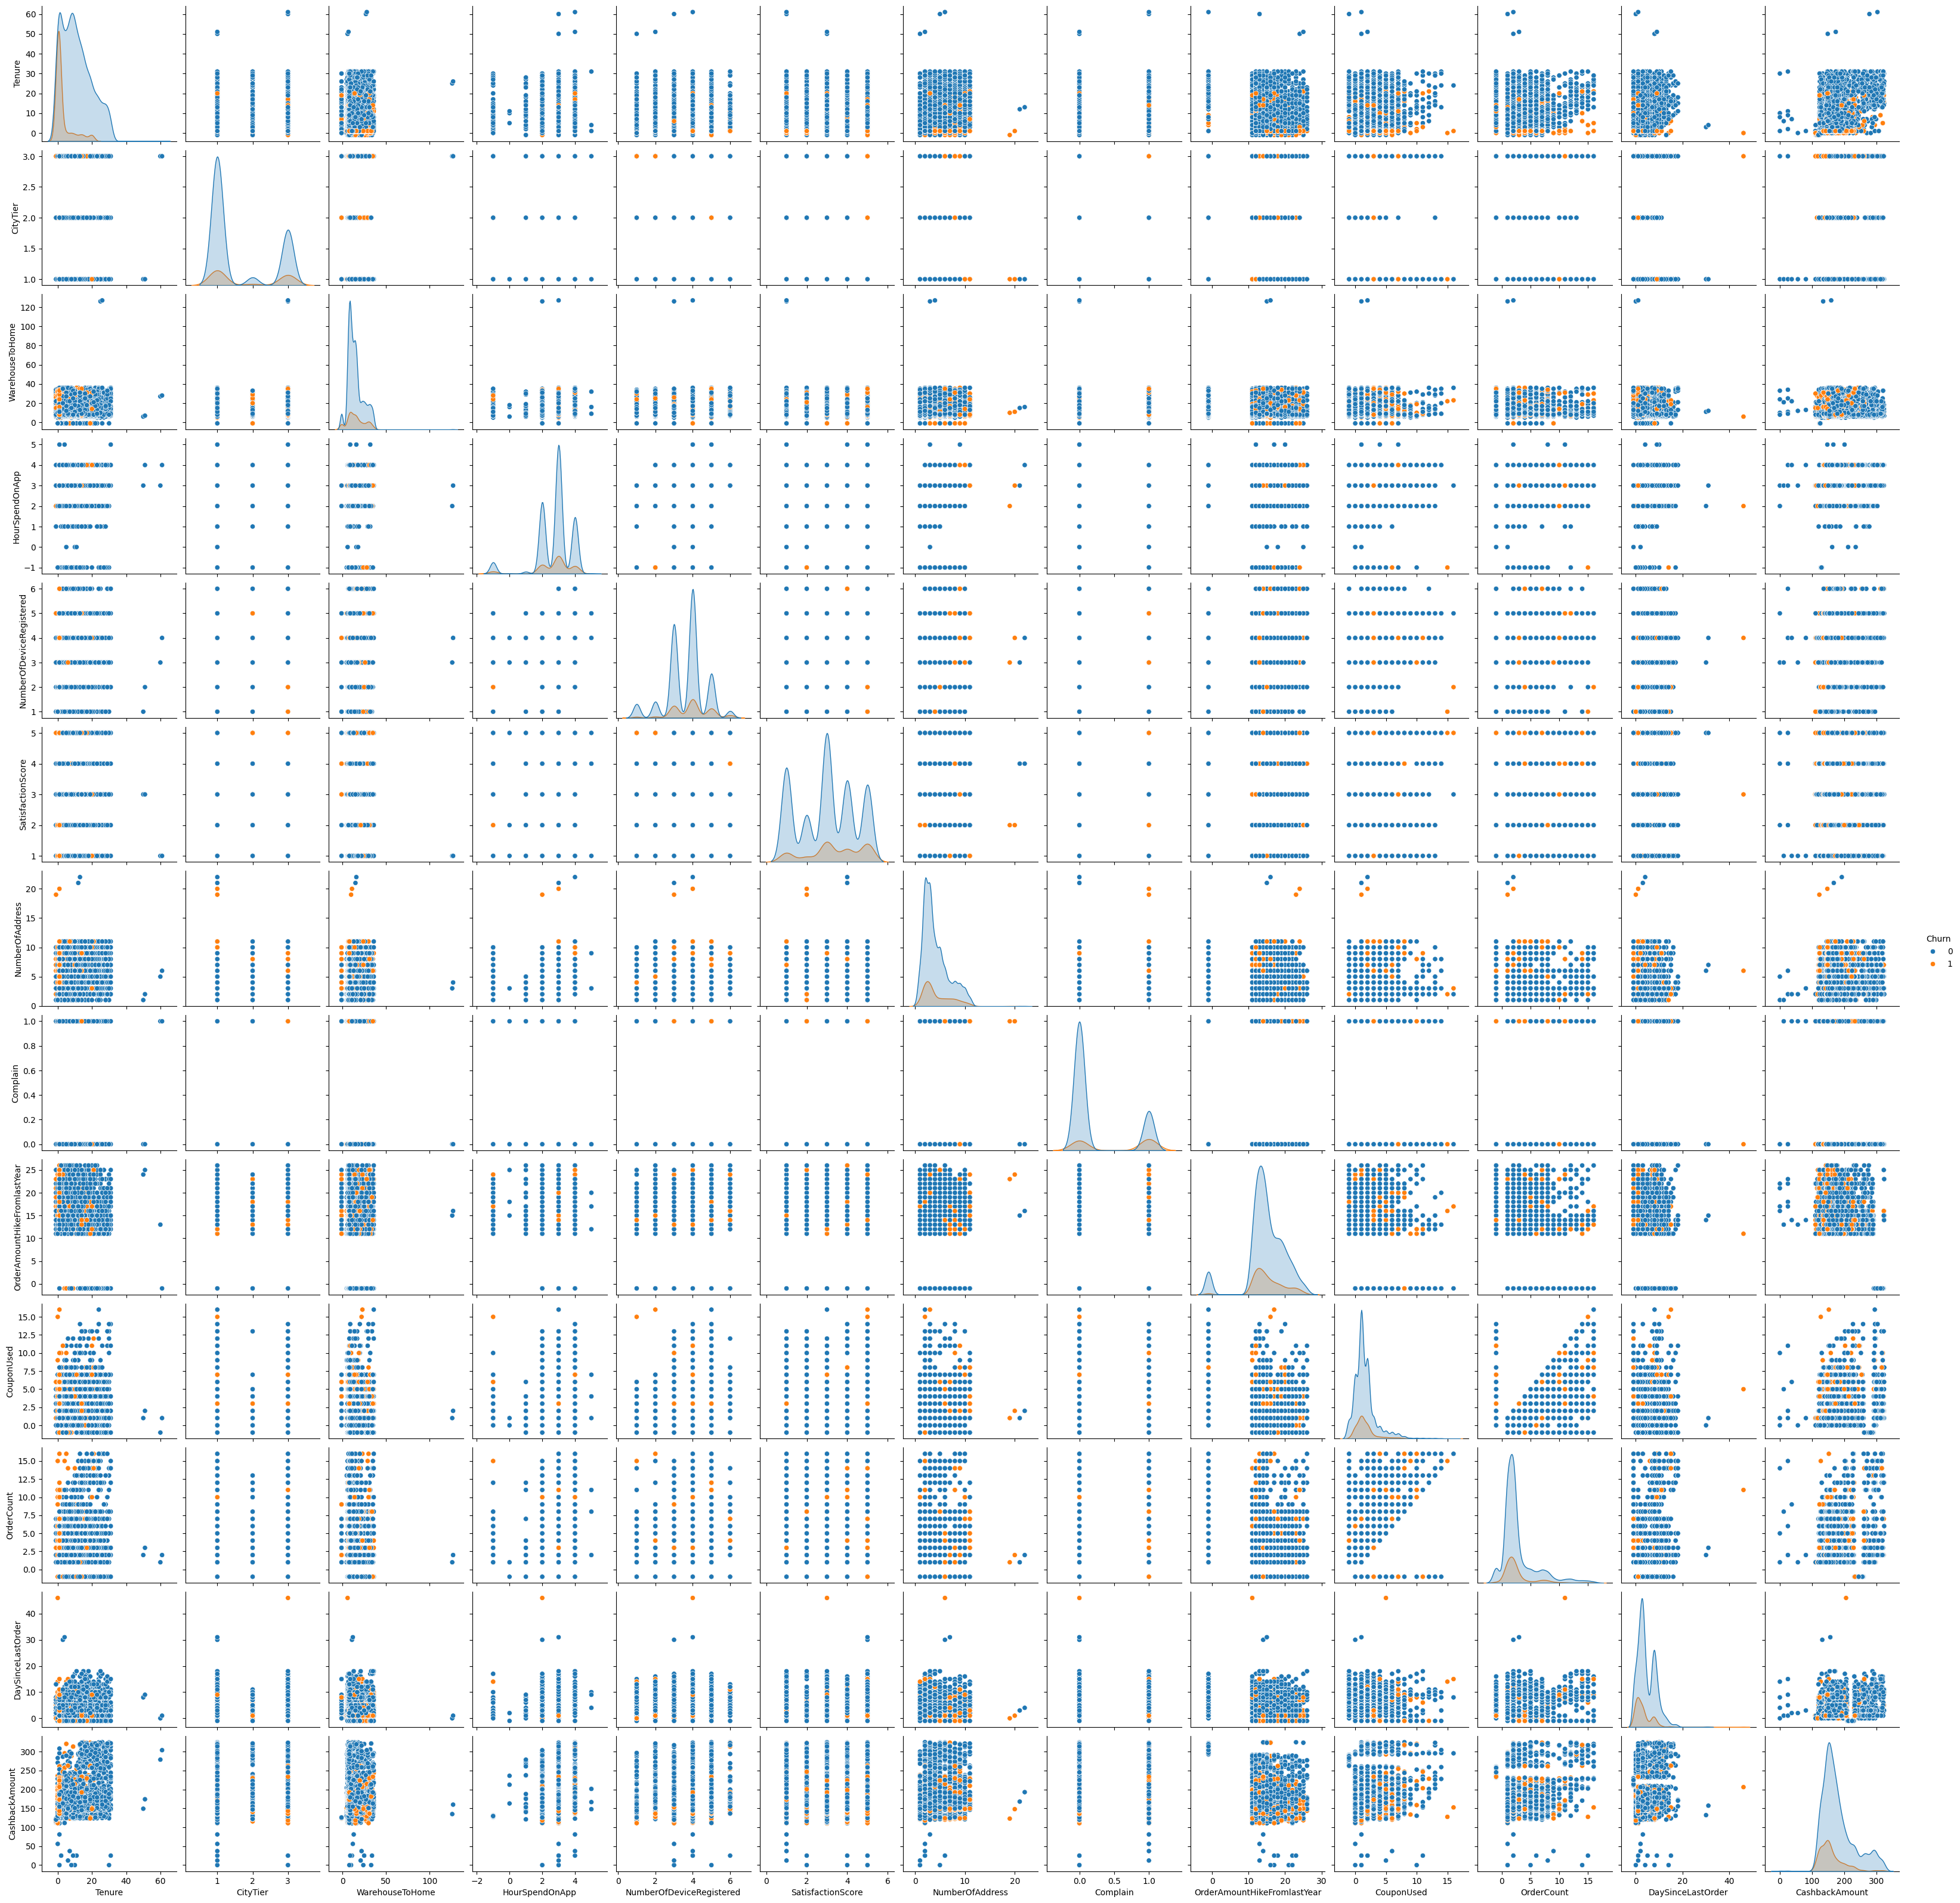

In [54]:
# Numerical-numerical variables
sns.pairplot(data = df, hue='Churn')
plt.show()

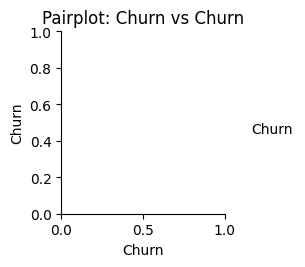

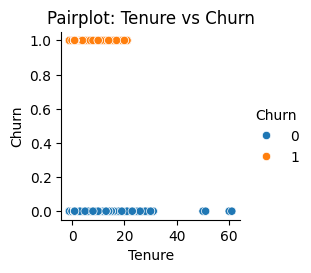

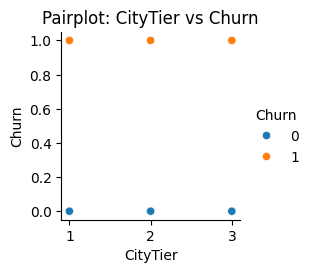

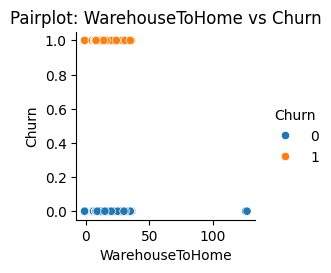

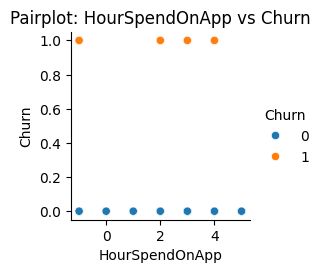

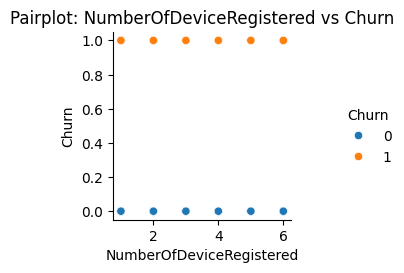

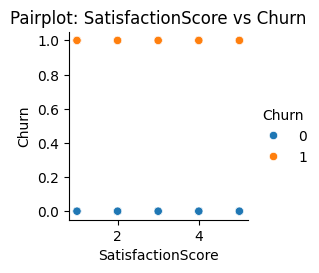

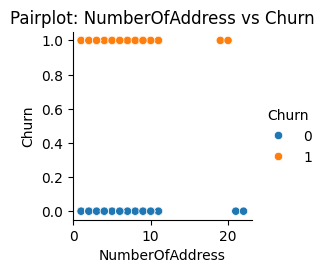

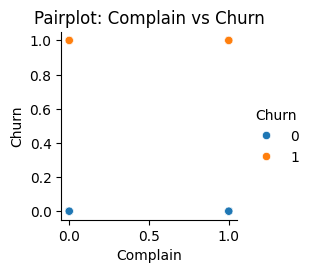

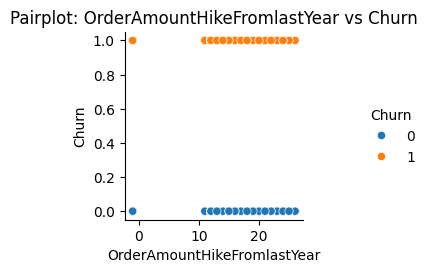

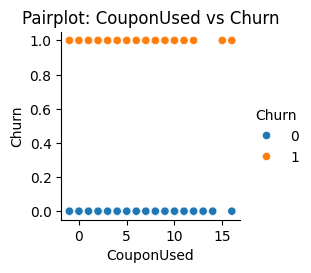

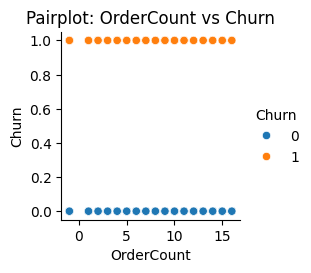

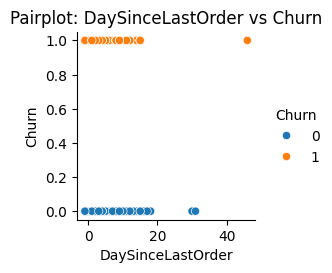

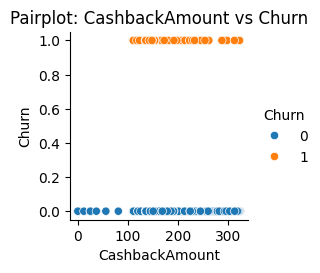

In [55]:
# Dependent variable
dependent_var = "Churn"

# Independent variables (only numeric ones)
independent_vars = df.select_dtypes(include=["number"]).columns

# Plot each independent variable vs the dependent variable
for col in independent_vars:
    sns.pairplot(df, x_vars=col, y_vars=dependent_var, hue=dependent_var, kind="scatter")
    plt.title(f"Pairplot: {col} vs {dependent_var}")
    plt.show()

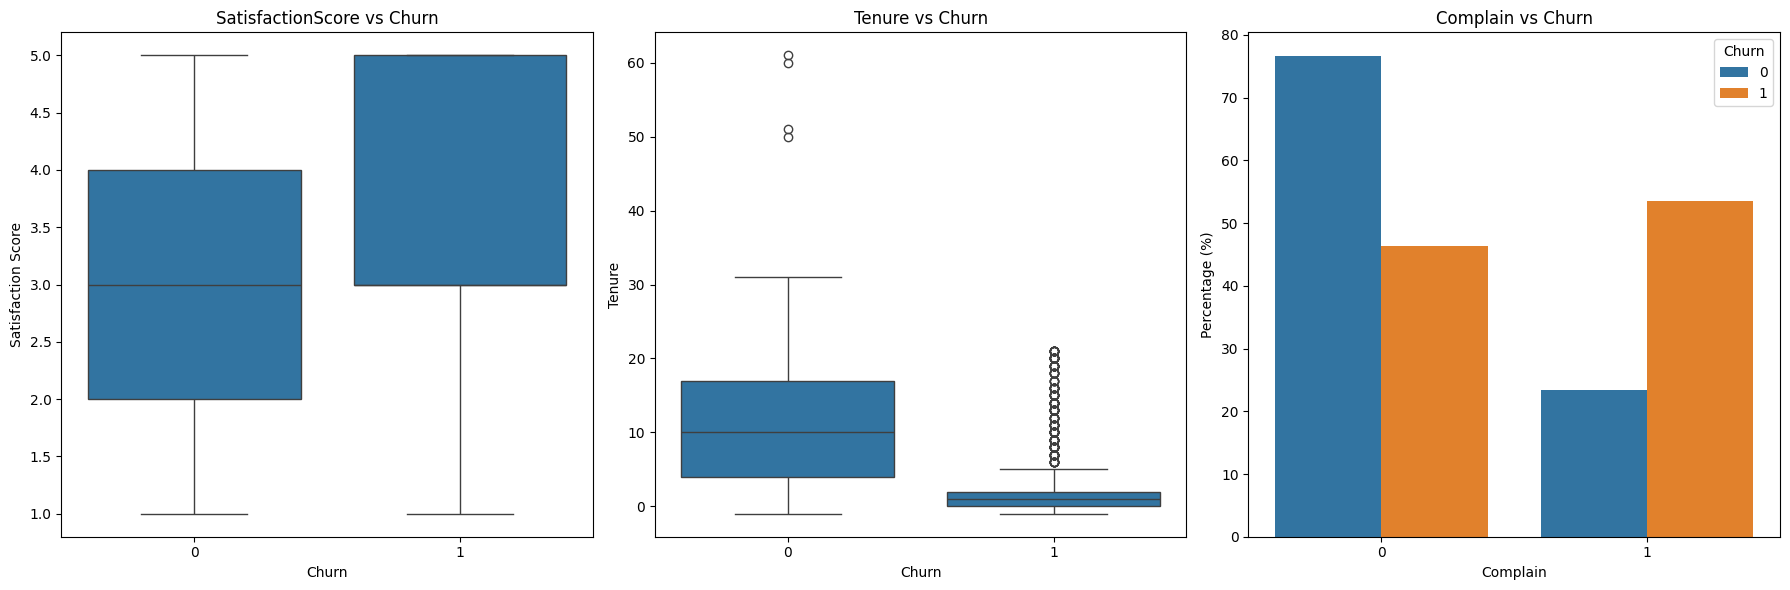

In [56]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot 1: SatisfactionScore vs Churn
sns.boxplot(x='Churn', y='SatisfactionScore', data=df, ax=axes[0])
axes[0].set_title('SatisfactionScore vs Churn')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Satisfaction Score')

# Plot 2: Tenure vs Churn
sns.boxplot(x='Churn', y='Tenure', data=df, ax=axes[1])
axes[1].set_title('Tenure vs Churn')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Tenure')

# Plot 3: Complain vs Churn (Bar Chart)
counts = (
    df.groupby(['Churn'])['Complain']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
)
sns.barplot(x="Complain", y="percentage", hue="Churn", data=counts, ax=axes[2])
axes[2].set_title('Complain vs Churn')
axes[2].set_xlabel('Complain')
axes[2].set_ylabel('Percentage (%)')

# Adjust layout
plt.tight_layout()
plt.show()

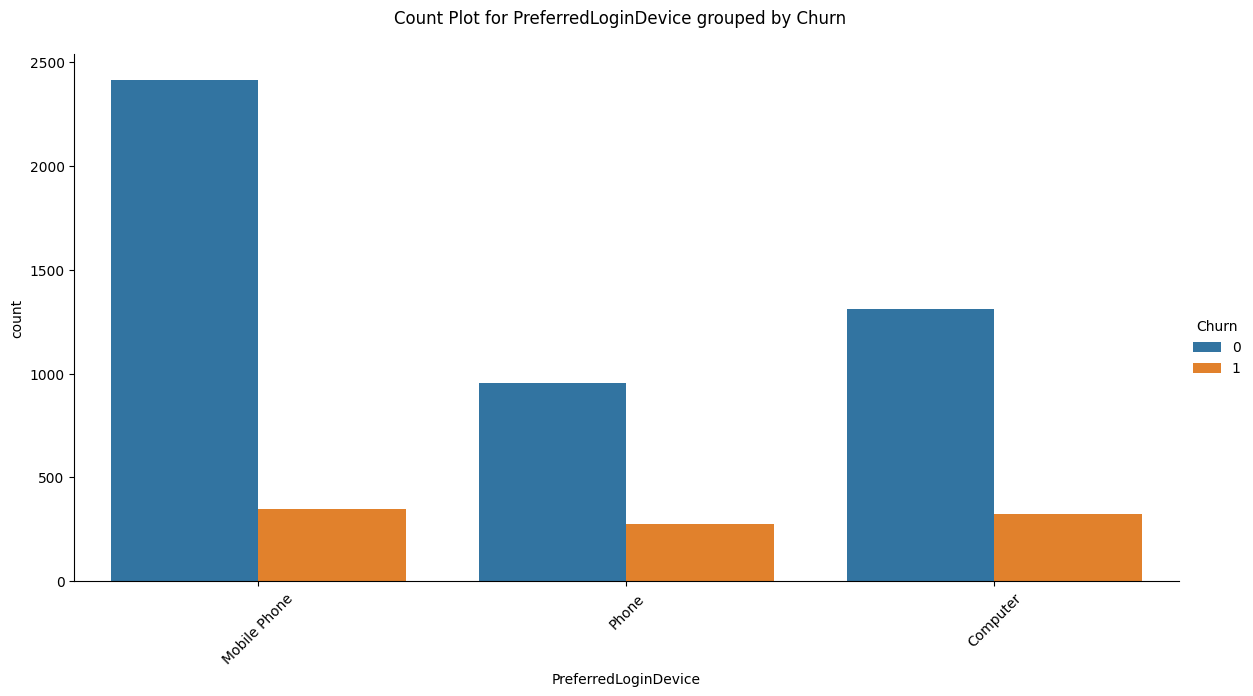

In [57]:
# Iterate over categorical columns
for col in df.select_dtypes(exclude=np.number).columns:
    # Ensure the 'Churn' column is in the data subset
    subset_df = df[[col, 'Churn']].dropna()  # Drop missing values if necessary
    
    # Create the catplot with increased x-axis space
    g = sns.catplot(
        x=col, kind='count', hue='Churn', data=subset_df, 
        height=6, aspect=2  # Adjust height and aspect for more space
    )
    
    # Set title and adjust x-axis labels
    g.fig.suptitle(f'Count Plot for {col} grouped by Churn', y=1.05)  # y adjusts title position
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    plt.show()

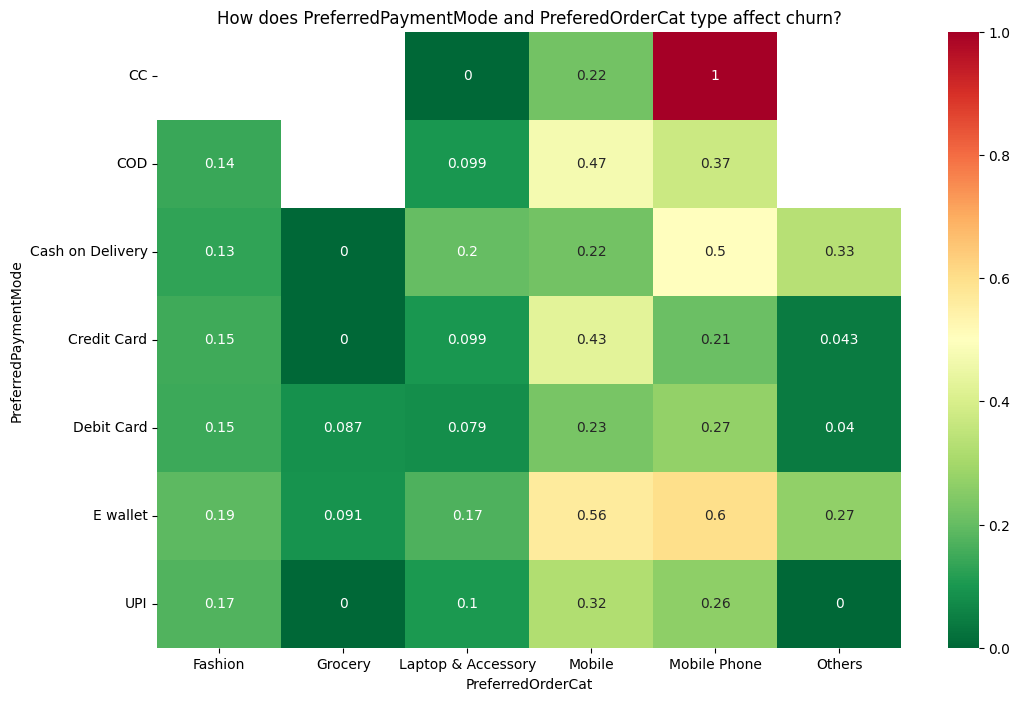

In [58]:
# Create pivot table
result = pd.pivot_table(
    data=df,
    index='PreferredPaymentMode',
    columns='PreferredOrderCat',
    values='Churn'
)

# Resize the chart by adjusting the figure size
plt.figure(figsize=(12, 8))  # Set width=12 and height=8

# Create heatmap
sns.heatmap(result, annot=True, cmap='RdYlGn_r').set_title(
    'How does PreferredPaymentMode and PreferedOrderCat type affect churn?'
)

# Show the plot
plt.show()

In [59]:
# Create pivot table with total counts
result = pd.pivot_table(
    data=df,
    index='PreferredPaymentMode',
    columns='PreferredOrderCat',
    aggfunc='size',  # Count occurrences
    fill_value=0     # Fill missing values with 0
)

# Resize the chart by adjusting the figure size
plt.figure(figsize=(12, 8))  # Adjust width and height as needed

# Create heatmap to visualize total counts
sns.heatmap(result, annot=True, fmt='d', cmap='RdYlGn_r').set_title(
    'How does PreferredPaymentMode and PreferedOrderCat type affect churn?'
)

plt.show()

In [60]:
'''
Learnings from exploratory data analysis
- Single and Married customers have a higher risk of churning
- Customer complaints increases the likelihood of churn
- Mobile customers have a higher risk of churn
- The longer the days since aa customer's last order, the higher the chance of them churning
'''

"\nLearnings from exploratory data analysis\n- Single and Married customers have a higher risk of churning\n- Customer complaints increases the likelihood of churn\n- Mobile customers have a higher risk of churn\n- The longer the days since aa customer's last order, the higher the chance of them churning\n"

In [61]:
# 2. Preprocessing

In [62]:
# 2.1 Imputation - SimpleImputer

    # All Nulls have been replaced

In [63]:
# Count NaN values for each column
nan_count_per_column = df.isna().sum()
print("NaN values per column:")
print(nan_count_per_column)

NaN values per column:
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
PreferredOrderCat              0
dtype: int64


In [64]:
# Encode categorical data

# List of columns to encode
columns_to_encode = ['PreferredLoginDevice', 'PreferredOrderCat', 'MaritalStatus', 'PreferredPaymentMode', 'Gender']

# Step 1: Handle missing values in the original columns
# Replace NaN values with a placeholder before encoding
df[columns_to_encode] = df[columns_to_encode].fillna('MISSING')

# Step 2: Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Step 3: Fit and transform the specified columns
encoded = encoder.fit_transform(df[columns_to_encode])

# Step 4: Create a DataFrame for the encoded columns
encoded_columns = encoder.get_feature_names_out(columns_to_encode)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns)

# Step 5: Combine the original DataFrame with the encoded DataFrame
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Step 6: Drop the original columns (optional, if they are no longer needed)
df = df.drop(columns=columns_to_encode)

# Step 7: Ensure no NaN values are present
assert df.isna().sum().sum() == 0, "NaN values found in the DataFrame!"

# Print the resulting DataFrame
print(df)

      Churn  Tenure  CityTier  WarehouseToHome  HourSpendOnApp  \
0         1       4         3                6             3.0   
1         1      -1         1                8             3.0   
2         1      -1         1               30             2.0   
3         1       0         3               15             2.0   
4         1       0         1               12            -1.0   
...     ...     ...       ...              ...             ...   
5625      0      10         1               30             3.0   
5626      0      13         1               13             3.0   
5627      0       1         1               11             3.0   
5628      0      23         3                9             4.0   
5629      0       8         1               15             3.0   

      NumberOfDeviceRegistered  SatisfactionScore  NumberOfAddress  Complain  \
0                            3                  2                9         1   
1                            4                 

In [65]:
# Count NaN values for each column
nan_count_per_column = df.isna().sum()
print("NaN values per column:")
print(nan_count_per_column)

NaN values per column:
Churn                                    0
Tenure                                   0
CityTier                                 0
WarehouseToHome                          0
HourSpendOnApp                           0
NumberOfDeviceRegistered                 0
SatisfactionScore                        0
NumberOfAddress                          0
Complain                                 0
OrderAmountHikeFromlastYear              0
CouponUsed                               0
OrderCount                               0
DaySinceLastOrder                        0
CashbackAmount                           0
PreferredLoginDevice_Computer            0
PreferredLoginDevice_Mobile Phone        0
PreferredLoginDevice_Phone               0
PreferredOrderCat_Fashion                0
PreferredOrderCat_Grocery                0
PreferredOrderCat_Laptop & Accessory     0
PreferredOrderCat_Mobile                 0
PreferredOrderCat_Mobile Phone           0
PreferredOrderCat_Others       

In [66]:
# Filter rows where any column has NaN
rows_with_nan = df[df.isna().any(axis=1)]
print("Rows with NaN values:")
print(rows_with_nan)

Rows with NaN values:
Empty DataFrame
Columns: [Churn, Tenure, CityTier, WarehouseToHome, HourSpendOnApp, NumberOfDeviceRegistered, SatisfactionScore, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount, PreferredLoginDevice_Computer, PreferredLoginDevice_Mobile Phone, PreferredLoginDevice_Phone, PreferredOrderCat_Fashion, PreferredOrderCat_Grocery, PreferredOrderCat_Laptop & Accessory, PreferredOrderCat_Mobile, PreferredOrderCat_Mobile Phone, PreferredOrderCat_Others, MaritalStatus_Divorced, MaritalStatus_Married, MaritalStatus_Single, PreferredPaymentMode_CC, PreferredPaymentMode_COD, PreferredPaymentMode_Cash on Delivery, PreferredPaymentMode_Credit Card, PreferredPaymentMode_Debit Card, PreferredPaymentMode_E wallet, PreferredPaymentMode_UPI, Gender_Female, Gender_Male]
Index: []

[0 rows x 35 columns]


In [67]:
df.dtypes

Churn                                      int64
Tenure                                     Int64
CityTier                                   int64
WarehouseToHome                            Int64
HourSpendOnApp                           float64
NumberOfDeviceRegistered                   int64
SatisfactionScore                          int64
NumberOfAddress                            int64
Complain                                   int64
OrderAmountHikeFromlastYear                Int64
CouponUsed                                 Int64
OrderCount                                 Int64
DaySinceLastOrder                          Int64
CashbackAmount                           float64
PreferredLoginDevice_Computer            float64
PreferredLoginDevice_Mobile Phone        float64
PreferredLoginDevice_Phone               float64
PreferredOrderCat_Fashion                float64
PreferredOrderCat_Grocery                float64
PreferredOrderCat_Laptop & Accessory     float64
PreferredOrderCat_Mo

In [68]:
# 2.3 Scaling - StandardScaler

In [69]:
X = df.drop(columns='Churn', axis=1)
y = df['Churn']

In [70]:

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data (standardize)
scaled_data = scaler.fit_transform(X)

# Create a new DataFrame with the scaled data
X = pd.DataFrame(scaled_data, columns=X.columns)

In [71]:
# 2.4 Feature Selection - SelectKBest
# Initialize SelectKBest with ANOVA F-value as the scoring function
k_best = SelectKBest(score_func=f_classif, k=2)  # Select top 2 features

# Fit and transform the data
X_selected = k_best.fit_transform(X, y)

# Get the scores of the features
feature_scores = k_best.scores_

# Display results
print("Feature Scores:", feature_scores)
print("Selected Features:\n", X.iloc[:, k_best.get_support(indices=True)].head())

Feature Scores: [7.61258868e+02 4.06705987e+01 5.55618590e+00 1.13374427e+00
 6.63432544e+01 6.33232123e+01 1.08826720e+01 3.75803024e+02
 9.52733340e+00 1.41053648e+00 6.84047885e-01 1.27431108e+02
 1.36931048e+02 1.47338274e+01 7.10282374e+01 3.52691456e+01
 1.24482377e+00 4.55227603e+01 1.01895143e+02 7.32687768e+01
 1.37421171e+02 1.70161808e+01 3.50121662e+00 1.31360896e+02
 1.90290238e+02 4.67067881e+00 3.99288066e+01 2.14806390e-01
 2.32424627e+01 5.93358763e+00 1.75474655e+01 9.75337673e-02
 4.82370382e+00 4.82370382e+00]
Selected Features:
      Tenure  Complain
0 -0.652527  1.584290
1 -1.228436  1.584290
2 -1.228436  1.584290
3 -1.113254 -0.631198
4 -1.113254 -0.631198


In [72]:
# Initialize SelectKBest with ANOVA F-value as the scoring function
k_best = SelectKBest(score_func=f_classif, k=2)  # Select top 2 features

# Fit and transform the data
k_best.fit(X, y)  # Fit only to get scores without transforming here

# Get the scores of the features
feature_scores = k_best.scores_

# Combine feature names with their scores
feature_scores_df = pd.DataFrame({
    "Feature": X.columns,
    "Score": feature_scores
}).sort_values(by="Score", ascending=False)

# Display results
print("Feature Scores:")
print(feature_scores_df)

# Display the selected features
selected_features = X.columns[k_best.get_support(indices=True)]
print("\nSelected Features (Top 2):")
print(selected_features)

Feature Scores:
                                  Feature       Score
0                                  Tenure  761.258868
7                                Complain  375.803024
24                   MaritalStatus_Single  190.290238
20         PreferredOrderCat_Mobile Phone  137.421171
12                         CashbackAmount  136.931048
23                  MaritalStatus_Married  131.360896
11                      DaySinceLastOrder  127.431108
18   PreferredOrderCat_Laptop & Accessory  101.895143
19               PreferredOrderCat_Mobile   73.268777
14      PreferredLoginDevice_Mobile Phone   71.028237
4                NumberOfDeviceRegistered   66.343254
5                       SatisfactionScore   63.323212
17              PreferredOrderCat_Grocery   45.522760
1                                CityTier   40.670599
26               PreferredPaymentMode_COD   39.928807
15             PreferredLoginDevice_Phone   35.269146
28       PreferredPaymentMode_Credit Card   23.242463
30          

In [73]:
# Create a pipeline with SelectKBest and a classifier
pipeline = Pipeline(steps=[
    ('feature_selection', SelectKBest(score_func=f_classif, k=2)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Perform cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.86767318 0.86856128 0.87033748 0.87566607 0.87744227]
Mean Accuracy: 0.8719360568383661


In [74]:
# 3. Training Time — Model building and comparison

# Data Splitting

## Split the data to create a train and test set
train, test = train_test_split(df, test_size=0.25)

# Before starting we have to make sure we include the right data in our model. We’ll split it into training and test and separate features from the target.

'''
train, test = train_test_split(train, test_size=0.25, random_state=123)
X = train.drop(columns='Churn', axis=1)
y = train['Churn']
'''

"\ntrain, test = train_test_split(train, test_size=0.25, random_state=123)\nX = train.drop(columns='Churn', axis=1)\ny = train['Churn']\n"

In [75]:
# Building the pipeline

## Selecting categorical and numeric features
numerical_ix = X.select_dtypes(include=np.number).columns
categorical_ix = X.select_dtypes(exclude=np.number).columns
## Create preprocessing pipelines for each datatype
numerical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
('encoder', OrdinalEncoder()),
('scaler', StandardScaler())])
## Putting the preprocessing steps together
preprocessor = ColumnTransformer([
('numerical', numerical_transformer, numerical_ix),
('categorical', categorical_transformer, categorical_ix)],
remainder='passthrough')

In [76]:
# Finding the best baseline model

## Creat list of classifiers we're going to try out
classifiers = [
KNeighborsClassifier(),
SVC(random_state=123),
DecisionTreeClassifier(random_state=123),
RandomForestClassifier(random_state=123),
AdaBoostClassifier(random_state=123),
GradientBoostingClassifier(random_state=123)
]
classifier_names = [
'KNeighborsClassifier()',
'SVC()',
'DecisionTreeClassifier()',
'RandomForestClassifier()',
'AdaBoostClassifier()',
'GradientBoostingClassifier()'
] 
model_scores = []

In [77]:
## Looping through the classifiers
for classifier, name in zip(classifiers, classifier_names):
  pipe = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('selector', SelectKBest(k=len(X.columns))),
  ('classifier', classifier)])
  score = cross_val_score(pipe, X, y, cv=10, scoring='roc_auc').mean() 
  model_scores.append(score)

In [78]:
model_performance = pd.DataFrame({
  'Classifier':
    classifier_names,  
  'Cross-validated AUC':
    model_scores
}).sort_values('Cross-validated AUC', ascending = False, ignore_index=True)
display(model_performance)

Classifier  Cross-validated AUC
0      RandomForestClassifier()             0.999446
1      DecisionTreeClassifier()             0.975324
2  GradientBoostingClassifier()             0.945979
3                         SVC()             0.943160
4        KNeighborsClassifier()             0.930981
5          AdaBoostClassifier()             0.903943

In [79]:
# Dictionary to store feature importance
feature_importances = {}

for classifier, name in zip(classifiers, classifier_names):
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(k=len(X.columns))),
        ('classifier', classifier)
    ])
    
    # Perform cross-validation and fit the pipeline
    score = cross_val_score(pipe, X, y, cv=10, scoring='roc_auc').mean()
    model_scores.append(score)
    
    # Fit the pipeline to extract feature importance
    pipe.fit(X, y)
    model = pipe.named_steps['classifier']
    
    # Save feature importance or coefficients based on classifier type
    if hasattr(model, 'feature_importances_'):  # Tree-based models
        feature_importances[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):  # Linear models
        feature_importances[name] = model.coef_.ravel()
    else:
        feature_importances[name] = None  # Not applicable for this model

# Create a DataFrame to display feature importance for each model
feature_importance_df = pd.DataFrame(feature_importances, index=X.columns)
display(feature_importance_df)

KNeighborsClassifier() SVC()  \
Tenure                                                  None  None   
CityTier                                                None  None   
WarehouseToHome                                         None  None   
HourSpendOnApp                                          None  None   
NumberOfDeviceRegistered                                None  None   
SatisfactionScore                                       None  None   
NumberOfAddress                                         None  None   
Complain                                                None  None   
OrderAmountHikeFromlastYear                             None  None   
CouponUsed                                              None  None   
OrderCount                                              None  None   
DaySinceLastOrder                                       None  None   
CashbackAmount                                          None  None   
PreferredLoginDevice_Computer                           None  None   
PreferredLoginDevice_Mobile Phone                       None  None   
PreferredLoginDevice_Phone                              None  None   
PreferredOrderCat_Fashion                               None  None   
PreferredOrderCat_Grocery                               None  None   
PreferredOrderCat_Laptop & Accessory                    None  None   
PreferredOrderCat_Mobile                                None  None   
PreferredOrderCat_Mobile Phone                          None  None   
PreferredOrderCat_Others                                None  None   
MaritalStatus_Divorced                                  None  None   
MaritalStatus_Married                                   None  None   
MaritalStatus_Single                                    None  None   
PreferredPaymentMode_CC                                 None  None   
PreferredPaymentMode_COD                                None  None   
PreferredPaymentMode_Cash on Delivery                   None  None   
PreferredPaymentMode_Credit Card                        None  None   
PreferredPaymentMode_Debit Card                         None  None   
PreferredPaymentMode_E wallet                           None  None   
PreferredPaymentMode_UPI                                None  None   
Gender_Female                                           None  None   
Gender_Male                                             None  None   

                                       DecisionTreeClassifier()  \
Tenure                                                 0.290934   
CityTier                                               0.030567   
WarehouseToHome                                        0.075666   
HourSpendOnApp                                         0.014200   
NumberOfDeviceRegistered                               0.031005   
SatisfactionScore                                      0.033051   
NumberOfAddress                                        0.074698   
Complain                                               0.066281   
OrderAmountHikeFromlastYear                            0.056121   
CouponUsed                                             0.004860   
OrderCount                                             0.028012   
DaySinceLastOrder                                      0.063645   
CashbackAmount                                         0.062002   
PreferredLoginDevice_Computer                          0.018398   
PreferredLoginDevice_Mobile Phone                      0.005191   
PreferredLoginDevice_Phone                             0.002537   
PreferredOrderCat_Fashion                              0.007121   
PreferredOrderCat_Grocery                              0.000000   
PreferredOrderCat_Laptop & Accessory                   0.021135   
PreferredOrderCat_Mobile                               0.004607   
PreferredOrderCat_Mobile Phone                         0.002514   
PreferredOrderCat_Others                               0.000000   
MaritalStatus_Divorced                        

In [97]:
# Did KNeighborsClassifier() and SVC() not run?

# Top Features for DecisionTreeClassifier

""" 
Tenure	0.281132
NumberOfAddress	0.084267
WarehouseToHome	0.070501
CashbackAmount	0.067307
DaySinceLastOrder	0.066563
"""
# Top Features for RandomForestClassifier

""" 
Tenure	0.203657
CashbackAmount	0.084967
WarehouseToHome	0.070548
Complain	0.064087
DaySinceLastOrder  0.061763 
"""
# Top Features for AdaBoostClassifier

""" 
Tenure 0.548477
NumberOfAddress 0.062266
Complain 0.057591
DaySinceLastOrder 0.045511
WarehouseToHome 0.042115
"""

# Top Features for GradientBoostingClassifier

""" 
Tenure 0.460891
Complain 0.113261
NumberOfAddress 0.087082
DaySinceLastOrder 0.055379
CashbackAmount 0.046176
"""

#Consisently the top features are Tenure, Complain, NumberOfAddress, DaySinceLastOrder, CashbackAmount, WarehouseToHome

# This makes sense that Tenure and DaySinceLastOrder are so closely related to churn (and Complain and CashbackAmount make sense), 
# but NumberOfAddress and WarehouseToHome are surprising

' \nTenure 0.460891\nComplain 0.113261\nNumberOfAddress 0.087082\nDaySinceLastOrder 0.055379\nCashbackAmount 0.046176\n'

In [98]:
## Code added to avoid missing k_range error

# Define k_range as a range of integers
k_range = range(1, len(X.columns) + 1)  # 1 to number of columns in X

In [99]:
# Hyperparameter Tuning

pipe = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('selector', SelectKBest(k=len(X.columns))),
  ('classifier', GradientBoostingClassifier(random_state=123))
])
# Full list of all hyperparameters
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'preprocessor', 'selector', 'classifier', 'preprocessor__force_int_remainder_cols', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__numerical', 'preprocessor__categorical', 'preprocessor__numerical__memory', 'preprocessor__numerical__steps', 'preprocessor__numerical__transform_input', 'preprocessor__numerical__verbose', 'preprocessor__numerical__imputer', 'preprocessor__numerical__scaler', 'preprocessor__numerical__imputer__add_indicator', 'preprocessor__numerical__imputer__copy', 'preprocessor__numerical__imputer__fill_value', 'preprocessor__numerical__imputer__keep_empty_features', 'preprocessor__numerical__imputer__missing_values', 'preprocessor__numerical__imputer__strategy', 'preprocessor__numerical__scaler__copy', 'preprocessor__numerica

In [103]:
# Define the parameter grid
grid = {
    "selector__k": k_range,
    "classifier__max_depth": [1, 3, 5],
    "classifier__learning_rate": [0.01, 0.1, 1],
    "classifier__n_estimators": [100, 200, 300]
}

# Use RandomizedSearchCV for faster exploration
gridsearch = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=grid,
    n_iter=20,  # Number of parameter combinations to sample
    n_jobs=-1,  # Use all available cores
    scoring='roc_auc',
    cv=3,  # Reduced cross-validation folds
    random_state=42
)

# Fit the model
gridsearch.fit(X, y)

# Print best parameters and score
print("Best Parameters:", gridsearch.best_params_)
print("Best ROC AUC Score:", gridsearch.best_score_)


Best Parameters: {'selector__k': 31, 'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 1}
Best ROC AUC Score: 0.9756709204007978


In [104]:
'''
Too slow!  Never finishes running!
'''

'''
grid = {
  "selector__k": k_range,
  "classifier__max_depth":[1,3,5],
  "classifier__learning_rate":[0.01,0.1,1],
  "classifier__n_estimators":[100,200,300,400]
}
gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs= 1, scoring='roc_auc')
gridsearch.fit(X, y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)
'''

'\ngrid = {\n  "selector__k": k_range,\n  "classifier__max_depth":[1,3,5],\n  "classifier__learning_rate":[0.01,0.1,1],\n  "classifier__n_estimators":[100,200,300,400]\n}\ngridsearch = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs= 1, scoring=\'roc_auc\')\ngridsearch.fit(X, y)\nprint(gridsearch.best_params_)\nprint(gridsearch.best_score_)\n'

AUCROC: 0.6528509327667206 
Accuracy: 0.71875


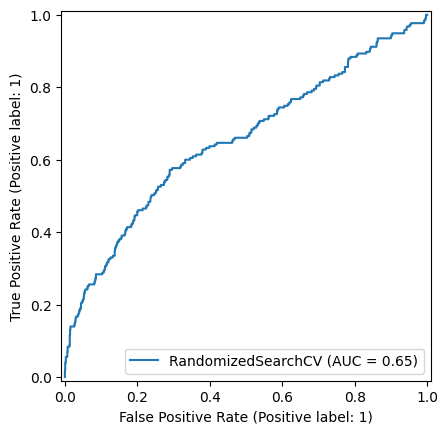

In [105]:
## Separate features and target for the test data
X_test = test.drop(columns='Churn', axis=1)
y_test = test['Churn']
## Refitting the training data with the best parameters
# gridsearch.refit
## Creating the predictions
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:, 1]
## Looking at the performance
print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))
# Plotting the ROC curve
#RocCurveDisplay(gridsearch, X_test, y_test)
#plt.show()

RocCurveDisplay.from_estimator(gridsearch, X_test, y_test)
plt.show()

In [107]:
# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Generate predictions and probabilities for the test data
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

In [108]:
# 4. Creating predictions for unseen data

AUCROC: 0.6528509327667206
Accuracy: 0.71875


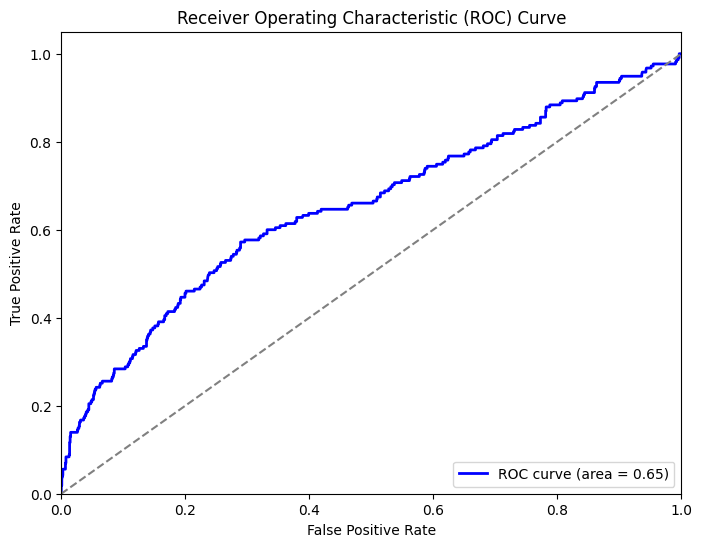

In [111]:
# Performance metrics
print('AUCROC:', roc_auc_score(y_test, y_score))
print('Accuracy:', accuracy_score(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [117]:
# print(len(X_test), len(y_test), len(y_pred), len(y_score))

print(X_test.shape, y_test.shape, y_pred.shape, y_score.shape)

(1408, 34) (1408,) (1408,) (1408,)


In [123]:
# Ensure alignment of y_test with X_test after preprocessing
X_test_processed = random_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
if len(X_test_processed) != len(y_test):
    y_test = y_test.iloc[:len(X_test_processed)]  # Align y_test length with processed X_test

# Generate predictions and probabilities
y_pred = random_search.best_estimator_.predict(X_test)
y_score = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Create a DataFrame to hold actual values and predicted probabilities
results_df = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),  # Reset index for alignment
    'Predicted_Prob': y_score
})

# Apply pandas.qcut to divide the probabilities into 4 quartiles
results_df['Quartile'] = pd.qcut(results_df['Predicted_Prob'], q=4, labels=False, duplicates='drop') + 1

# Analyze the quartiles
quartile_summary = results_df.groupby('Quartile').agg(
    Count=('Actual', 'size'),
    Avg_Probability=('Predicted_Prob', 'mean'),
    Actual_Rate=('Actual', 'mean')
).sort_index(ascending=False)

# Display quartile analysis
print(quartile_summary)

# Plot quartile performance
plt.figure(figsize=(10, 6))
plt.bar(quartile_summary.index, quartile_summary['Actual_Rate'], alpha=0.7, label='Actual Positive Rate')
plt.xlabel('Quartile (4 = Highest Predicted Probability)')
plt.ylabel('Actual Positive Rate')
plt.title('Quartile Analysis of Model Predictions')
plt.xticks(quartile_summary.index)
plt.legend()
plt.show()

# Optional: Feature Importance Analysis
if hasattr(random_search.best_estimator_.named_steps['classifier'], 'feature_importances_'):
    feature_importance = random_search.best_estimator_.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    print(feature_importance_df)


          Count  Avg_Probability  Actual_Rate
Quartile                                     
4           352         0.952899     0.281250
3           351         0.160602     0.122507
2           353         0.000416     0.101983
1           352         0.000001     0.105114


ValueError: All arrays must be of the same length

In [ ]:
## Look into feature selection and tuning the models once created.  Hyperparameter tuning for the random forest model and stopping rules etc of the model to improve performance and explain.  get_pameters() function?  Iterate and see what works best for random forest.

In [125]:
# Feature selection using SelectKBest with mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=10)  # Select top 10 features
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())

Selected Features: ['Tenure', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'Complain', 'DaySinceLastOrder', 'CashbackAmount', 'PreferredLoginDevice_Mobile Phone', 'PreferredOrderCat_Mobile Phone', 'MaritalStatus_Married', 'MaritalStatus_Single']


In [126]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='roc_auc',
    cv=3,  # Cross-validation folds
    random_state=42,
    n_jobs=-1  # Use all cores
)

# Fit the RandomizedSearchCV
random_search.fit(X_selected, y)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)


Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}
Best ROC AUC Score: 0.9628436041215602


In [127]:
# Enable out-of-bag (OOB) scoring
rf_model = RandomForestClassifier(
    n_estimators=200,  # Set based on previous tuning
    max_depth=20,  # Optimized value
    min_samples_split=5,
    min_samples_leaf=2,
    oob_score=True,  # Enable OOB scoring
    random_state=42
)

# Fit the model
rf_model.fit(X_selected, y)

# Print OOB score
print("OOB Score:", rf_model.oob_score_)

OOB Score: 0.9241563055062167
